### 0. Initialisation

In [2]:
save_path = "/Users/aljoscha/Downloads/locustVR_data"

import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import importlib

from LocustVR_data_analysis import utils_local

importlib.reload(utils_local)
from LocustVR_data_analysis.utils_local import plt_density, default_style, generate_plot_type, generate_time_windows

### 2. Load data

In [3]:
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

In [3]:
grouped = df.groupby("animal_id")["trial_id"].agg(["max", "nunique"])
print(grouped)

           max  nunique
animal_id              
0           31       32
1           29       30
2           31       32
3           14       15
4           31       32
5           34       35
6           35       36
7           18       19
8           26       27
9           25       26
10          21       22
11          25       26
12          30       31
13           6        7
14          34       35
15          26       27
16          32       33
17          28       29
18          33       34
19          27       28
20          21       22
21          30       31


In [4]:
print(df)

                  X           Y   heading     ts  trial_id  state_type  \
0          0.001724   -0.000008  2.978185  -7211         0           0   
1         -0.008445    0.001091  2.978185  -7210         0           0   
2         -0.018577    0.002156  2.978185  -7209         0           0   
3         -0.028663    0.003190  2.978185  -7208         0           0   
4         -0.038699    0.004192  2.970926  -7207         0           0   
...             ...         ...       ...    ...       ...         ...   
7853448 -160.593521 -118.996429  1.157819   6955        30           1   
7853449 -160.593476 -118.996619  1.190118   6956        30           1   
7853450 -160.593417 -118.996833  1.190118   6957        30           1   
7853451 -160.593342 -118.997071  1.120649   6958        30           1   
7853452 -160.593253 -118.997336  1.120649   6959        30           1   

         animal_id  heading_rel  heading_rel_flip  constant_distance  \
0                0    -0.147917        

### 3. Visualisation

In [4]:
save_plots = False
angle_version = ["heading_rel", "heading_rel_flip"]
select = ["data", "angle", "angular_velocity"]

t_max = df['ts'].max()
sec = t_max / 60
limits = [[-3000 / sec, 8000 / sec], [-180, 180]]

plot_type = ["hist", "kde"] # Options: hist, kde

angle_bins = np.linspace(-np.pi, np.pi, 360)  # 1° bins
# time_ts = [-2000, 0, 500, 1000, 6000, 9494]
time_ts = [-2000, 750, 6500, 9494]
critical_time1 = time_ts / sec
time_seconds = np.array([2, 10])
critical_time2 = time_seconds * sec  # Convert seconds to the same scale as 'ts'

#### 3.1 Angle over time

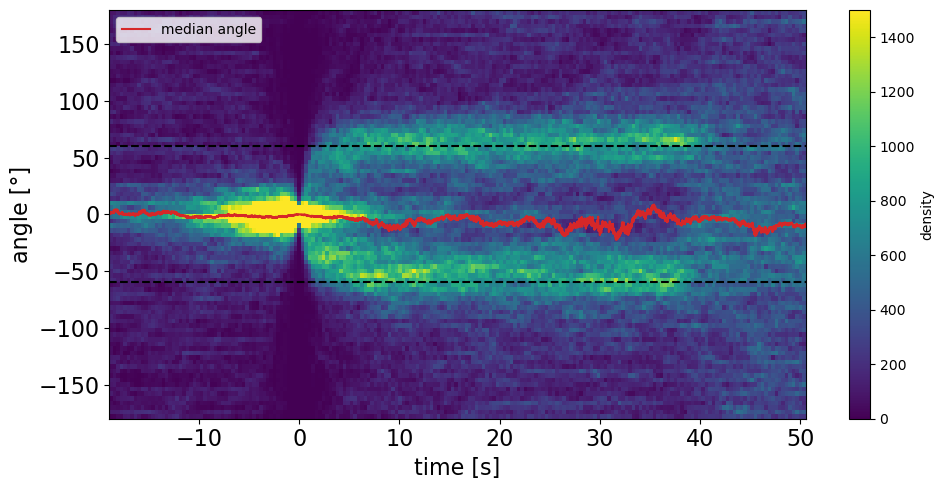

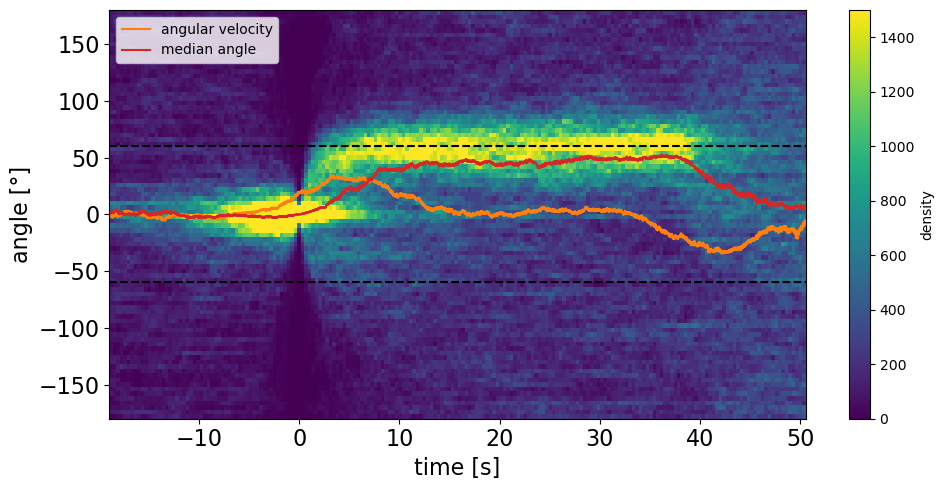

In [12]:
angle_version = ["heading_rel", "heading_rel_flip"]
for version in angle_version:
    fig, ax = plt.subplots(figsize=(10, 5))
    if "data" in select:
        # Prepare data
        x = df['ts'] / sec
        y = np.degrees(df[version])

        # Heatmap with log color normalization for better contrast
        heatmap = ax.hist2d(
            x, y,
            bins=[200, 90],  # time x angle resolution
            range=[[limits[0][0], limits[0][1]], [limits[1][0], limits[1][1]]],
            cmap='viridis',
            # norm=LogNorm(vmin=1, vmax=1000),
            density=False,
            vmax=1500
        )

        cbar = fig.colorbar(heatmap[3], ax=ax)
        cbar.set_label("density")

    # Median angle
    df_mean = df.groupby('ts', as_index=False)[version].median()

    # Angular velocity
    df_median = df.groupby('ts', as_index=False)[version].median()
    df_median = df_median.sort_values('ts')
    df_median['heading_smooth'] = df_median[version].rolling(window=1500, center=True).mean()
    df_median['angular_velocity'] = df_median['heading_smooth'].diff() / df_median['ts'].diff()
    df_median = df_median.dropna(subset=['angular_velocity'])
    if version == "heading_rel_flip":
        if "angular_velocity" in select:
            ax.plot(df_median['ts'] / sec, np.degrees(df_median['angular_velocity'] * 1200), color='C1', label='angular velocity')
    if "angle" in select:
        ax.plot(df_mean['ts'] / sec, np.degrees(df_mean[version]), color='C3', label='median angle')

    # ±60° reference
    ax.axhline(60, color='black', linestyle='--')
    ax.axhline(-60, color='black', linestyle='--')

    # Labels, limits, legend
    default_style(x_label="time [s]", y_label="angle [°]", limits=limits)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.legend(loc='upper left')

    # plt.savefig(os.path.join(save_path, 'angle_vs_time_heatmap.png'), format='png', dpi=500)
    plt.show()

#### 3.2 Desity of angles (for time bins)

##### 3.2.1 Histogram

heading_rel_flip


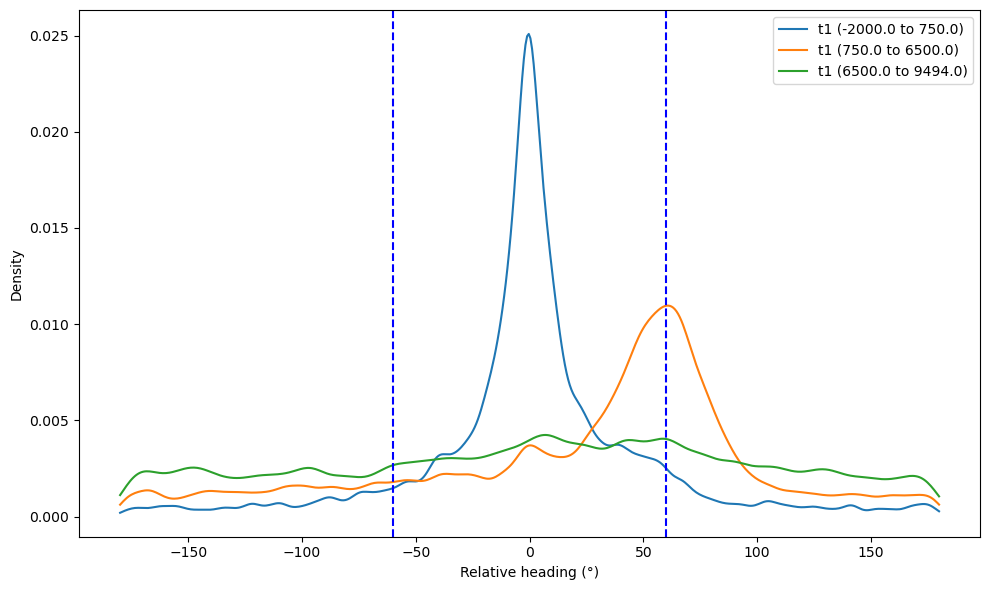

heading_rel


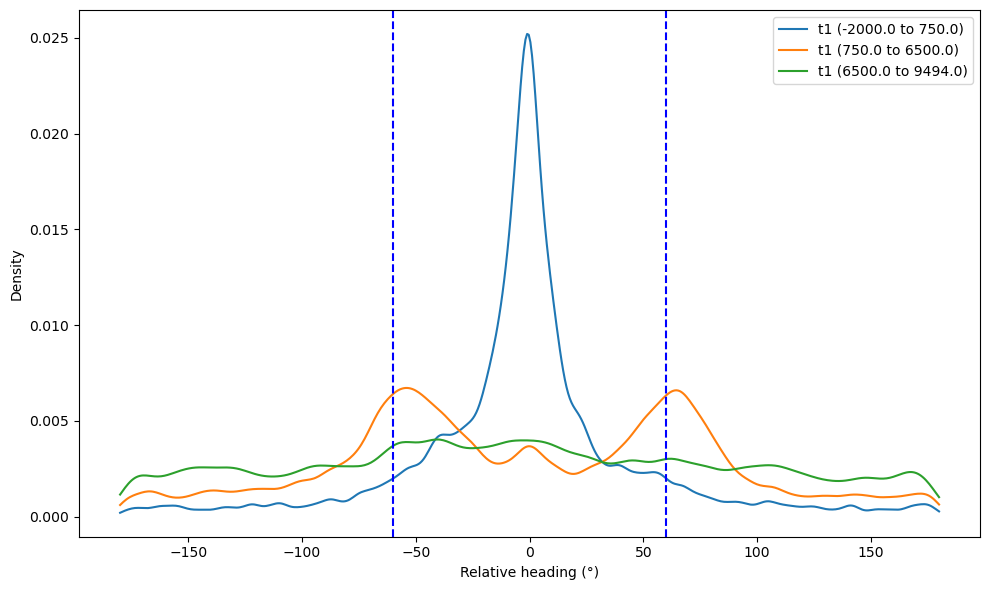

In [40]:
time_windows = generate_time_windows(time_ts)
plot_type = ["kde"]
angle_version = ["heading_rel_flip", "heading_rel"]
for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)
    for version in angle_version:
        print(version)
        plt.figure(figsize=(10, 6))
        plt_density(df, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
        # plt.savefig(os.path.join(save_path, f'{type}_{version}.png'), format='png', dpi=500)
        plt.show()

Plot type: kde | Angle version: heading_rel_flip
  Plotting for animal: 0


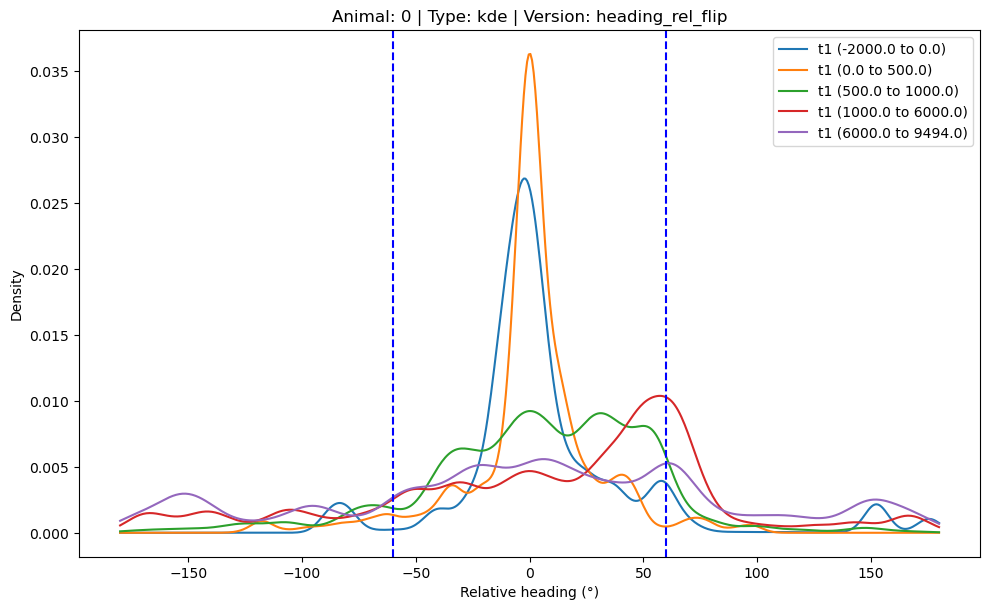

  Plotting for animal: 1


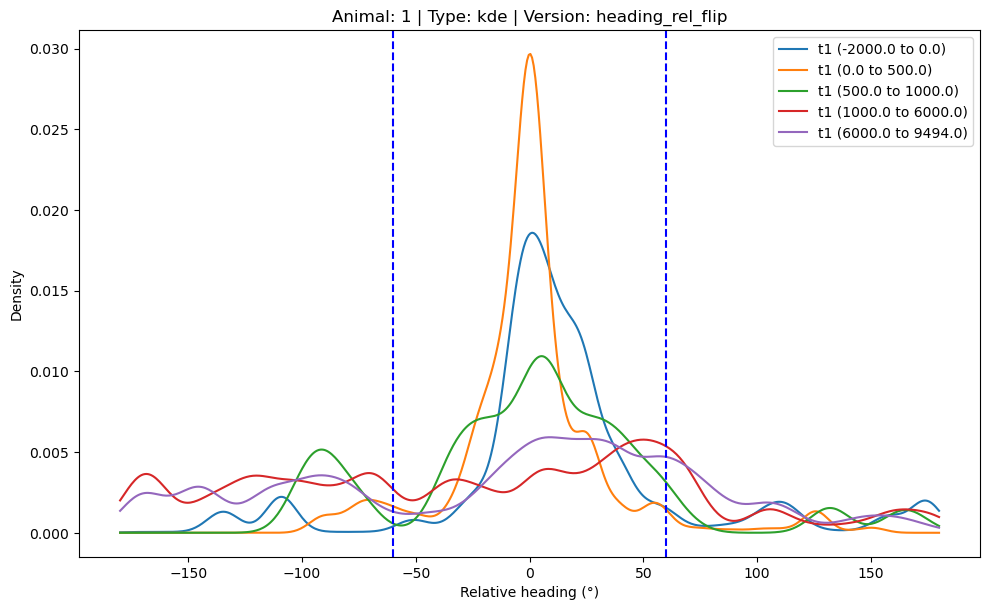

  Plotting for animal: 2


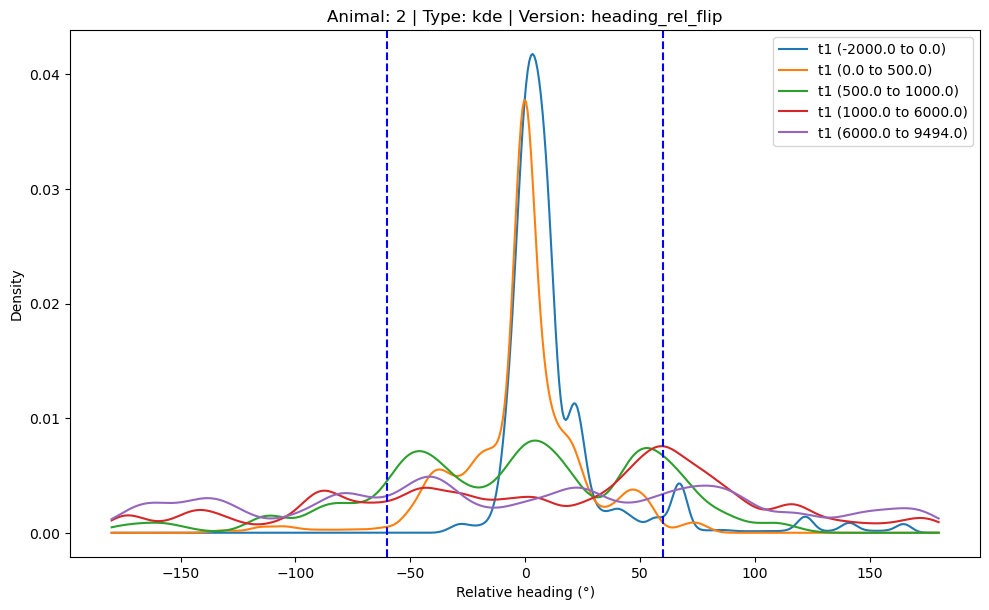

  Plotting for animal: 3


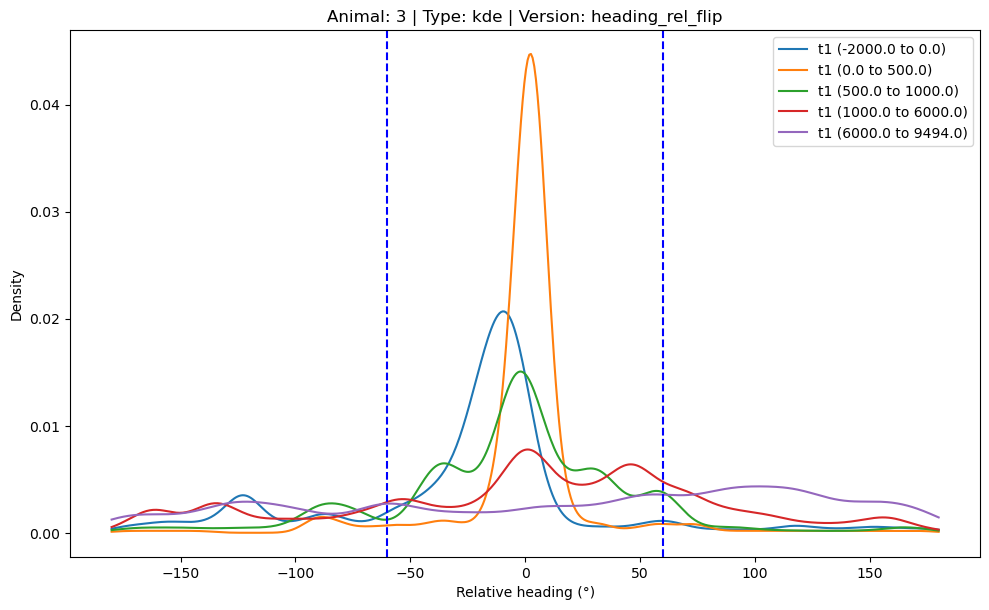

  Plotting for animal: 4


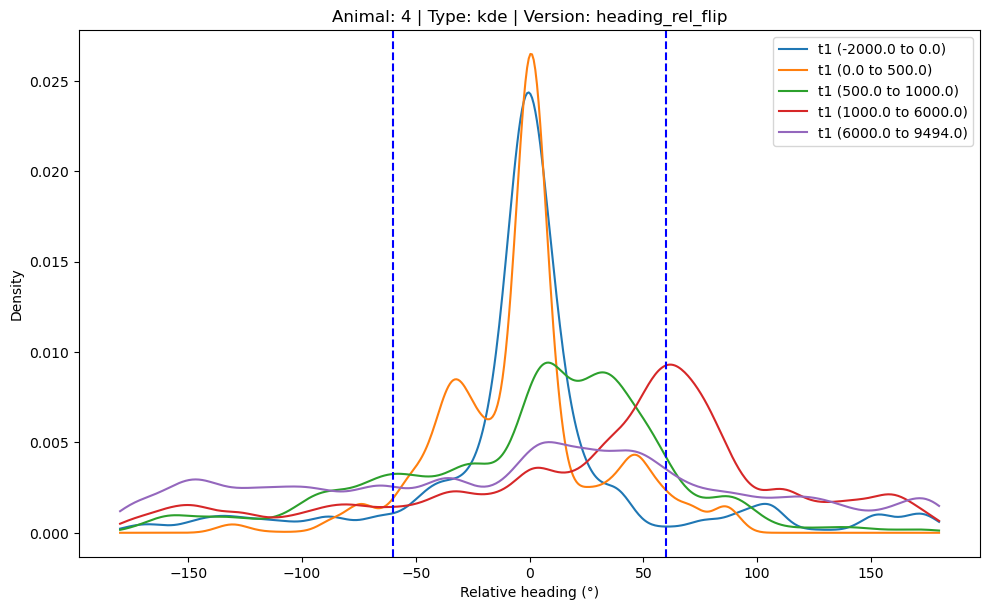

  Plotting for animal: 5


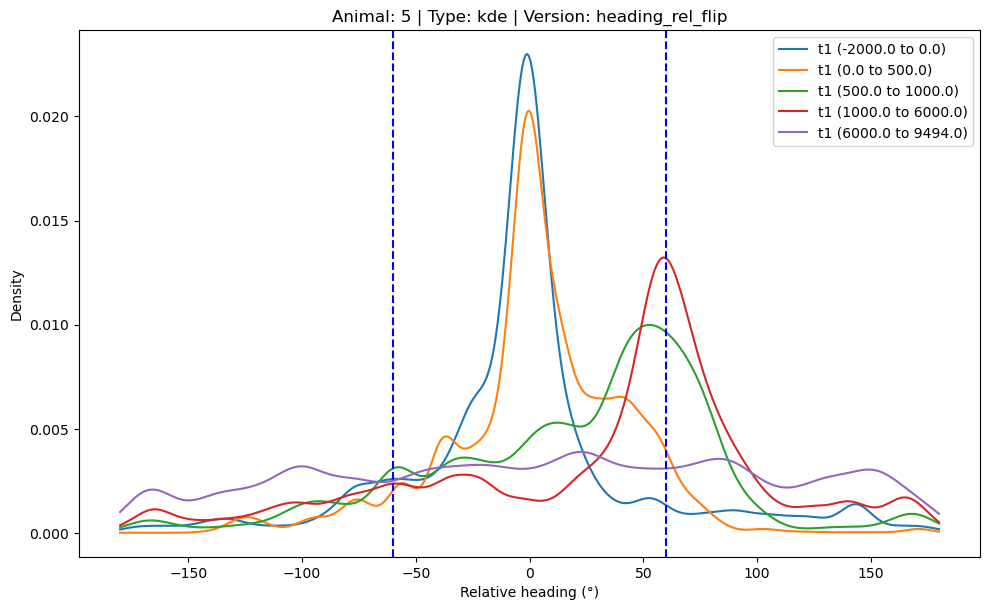

  Plotting for animal: 6


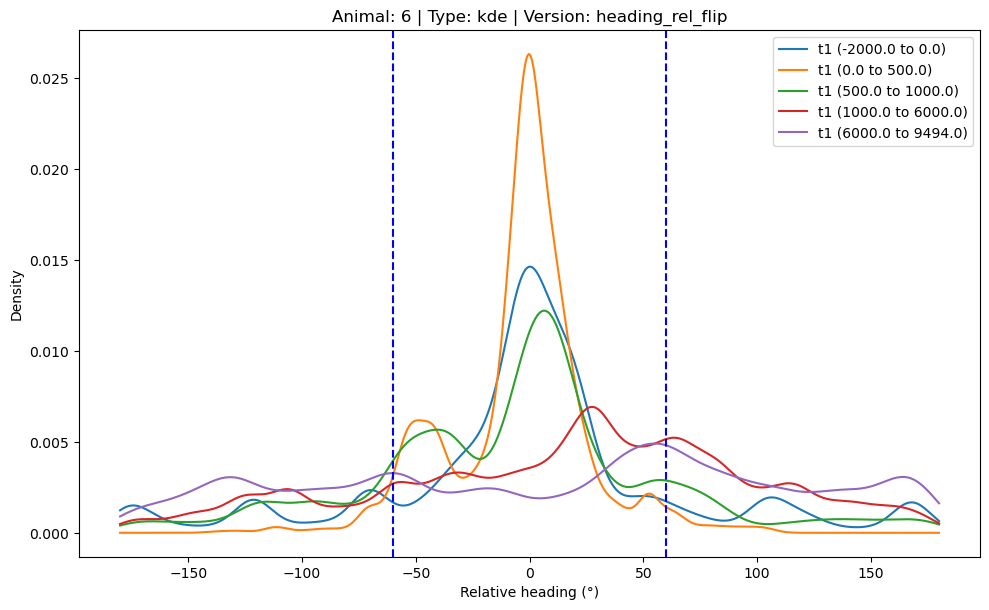

  Plotting for animal: 7


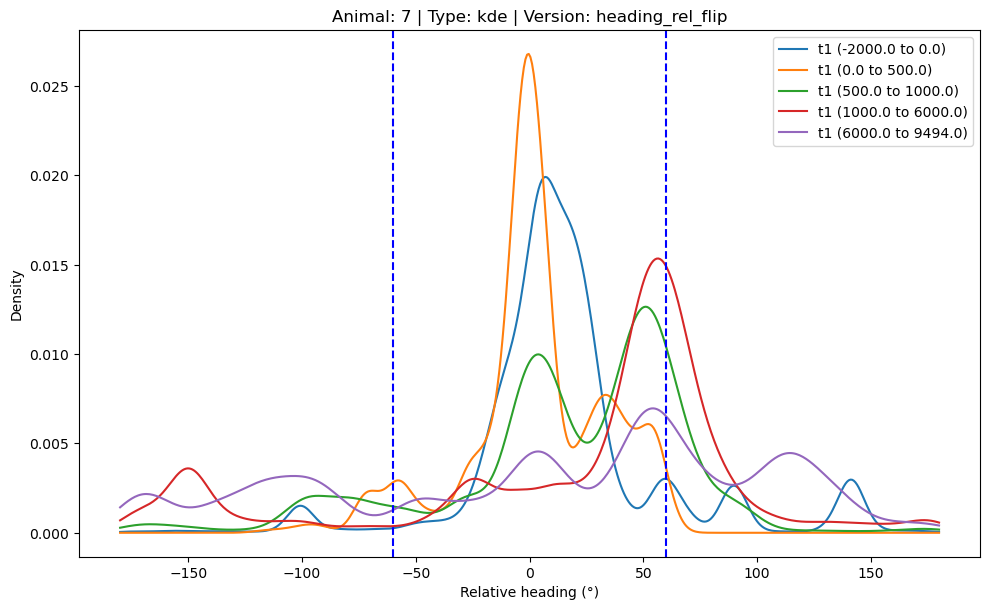

  Plotting for animal: 8


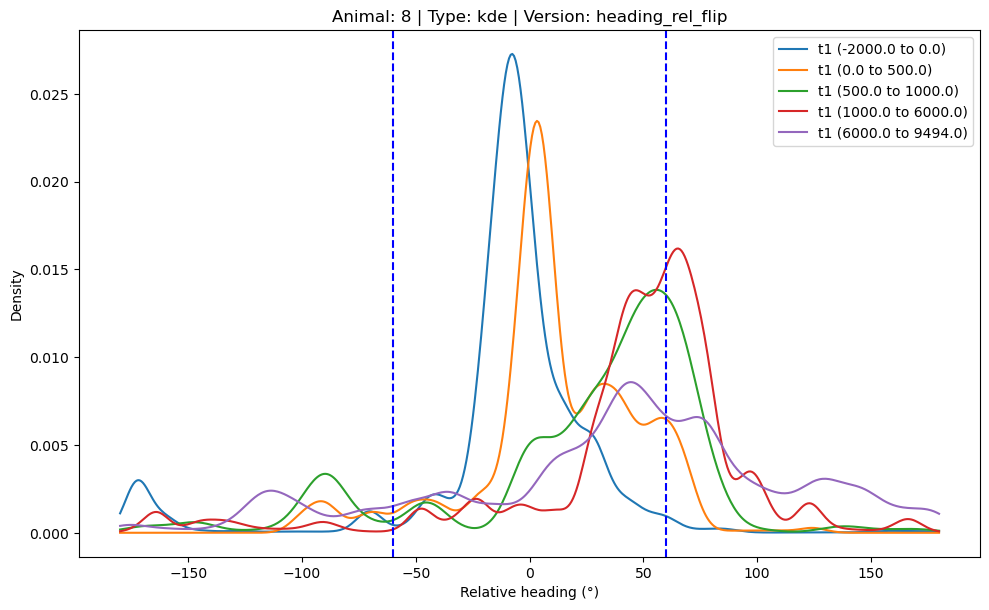

  Plotting for animal: 9


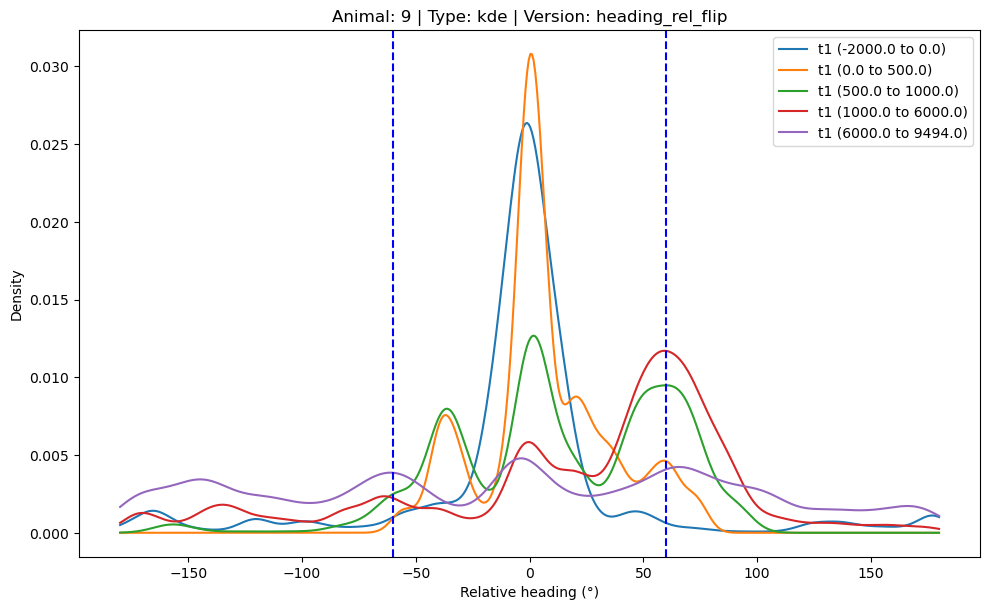

  Plotting for animal: 10


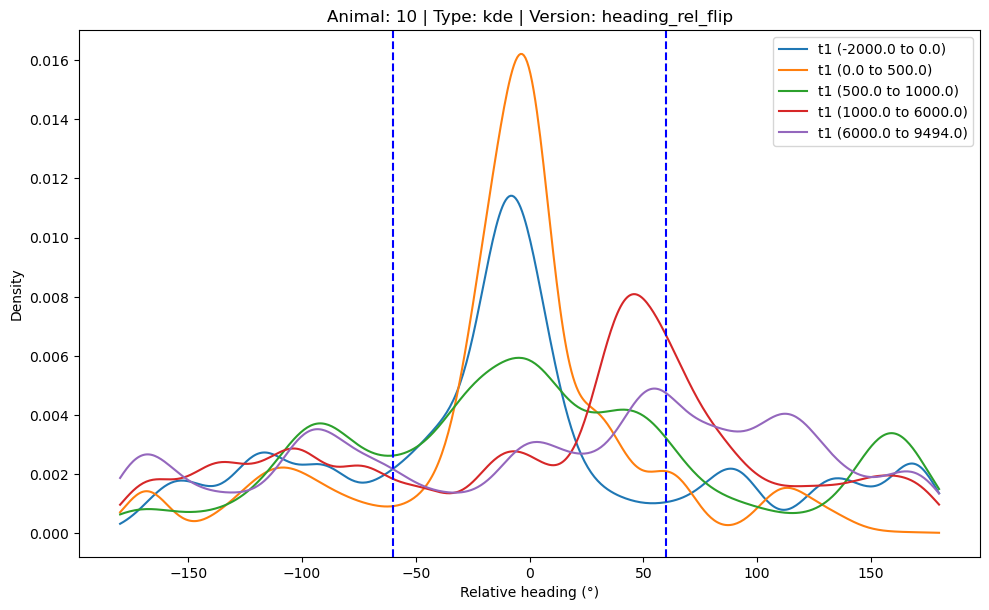

  Plotting for animal: 11


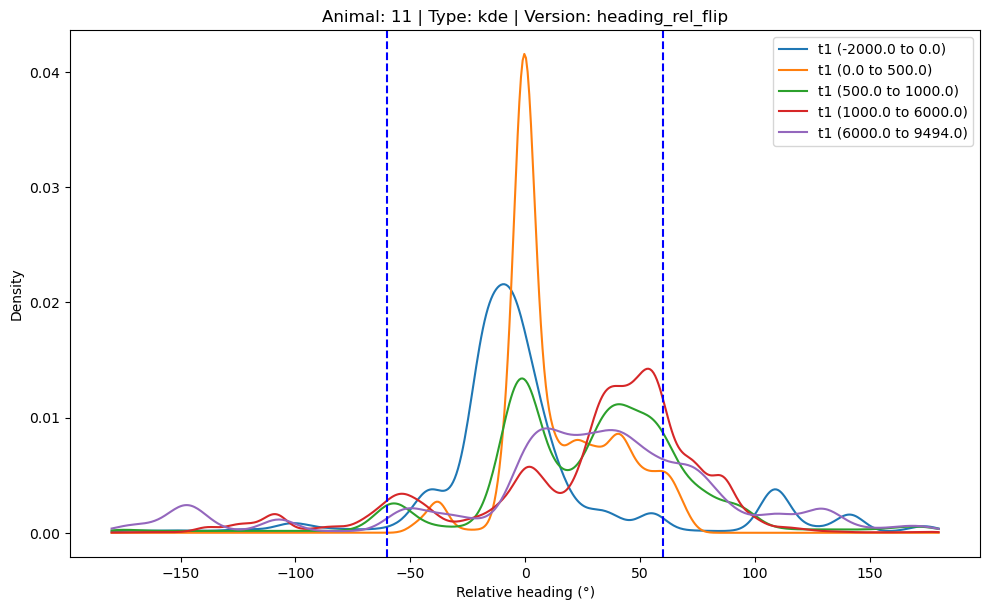

  Plotting for animal: 12


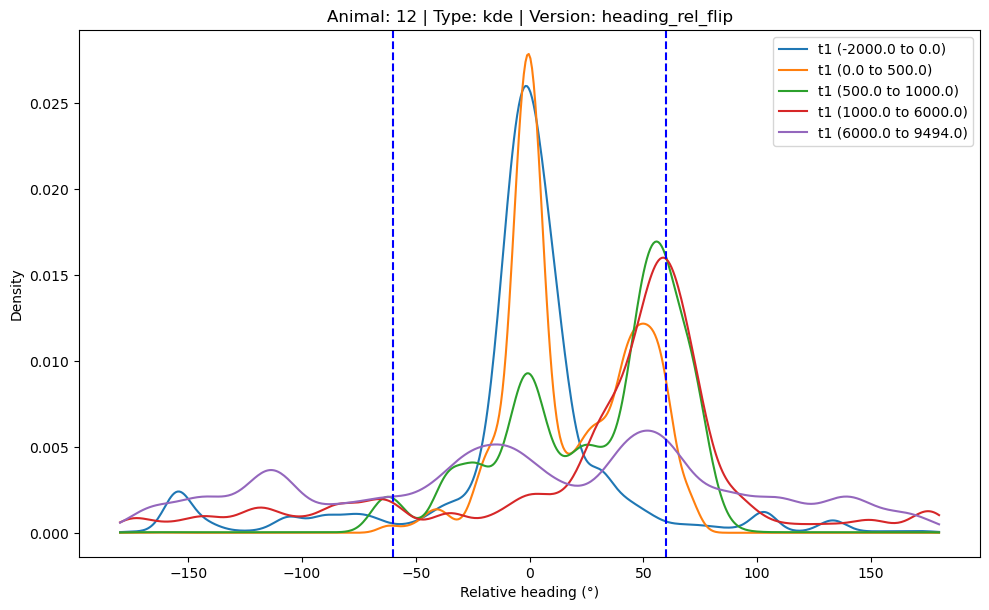

  Plotting for animal: 13


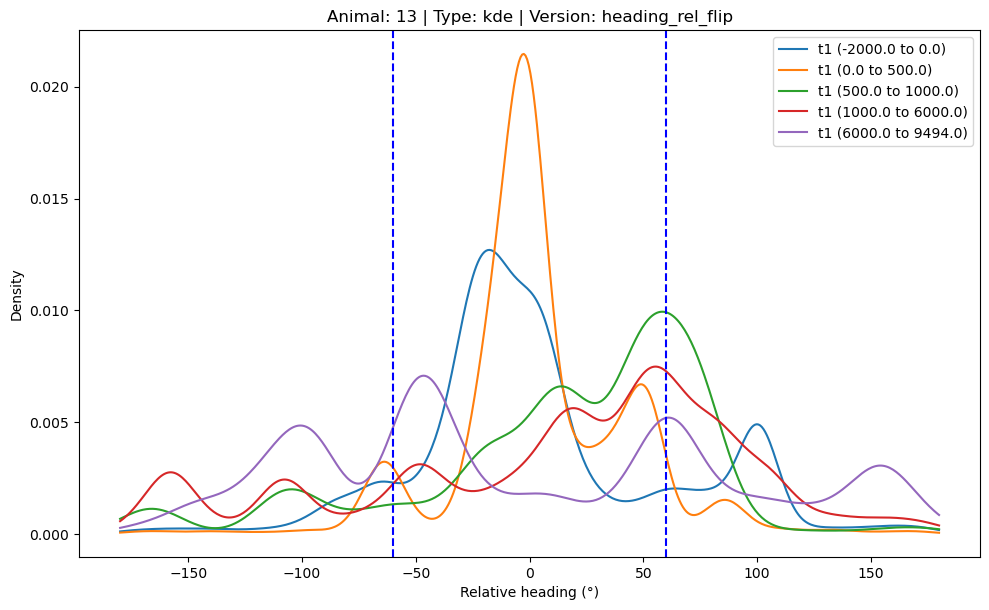

  Plotting for animal: 14


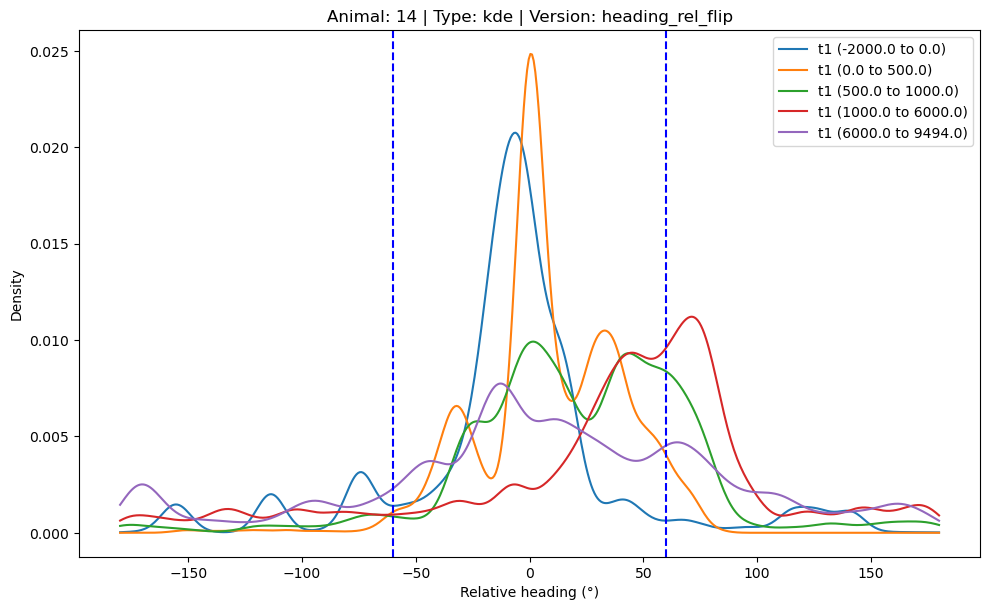

  Plotting for animal: 15


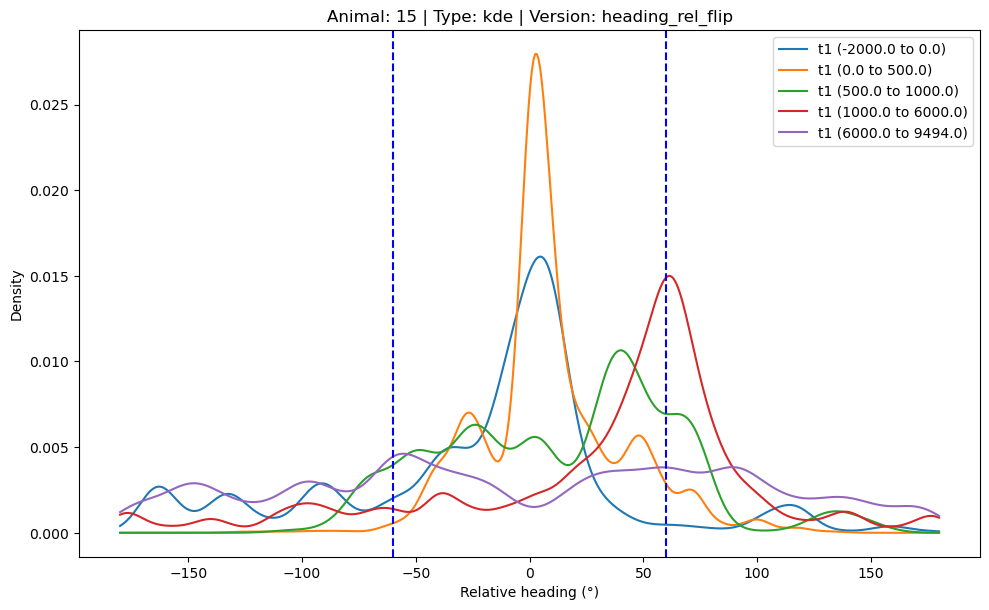

  Plotting for animal: 16


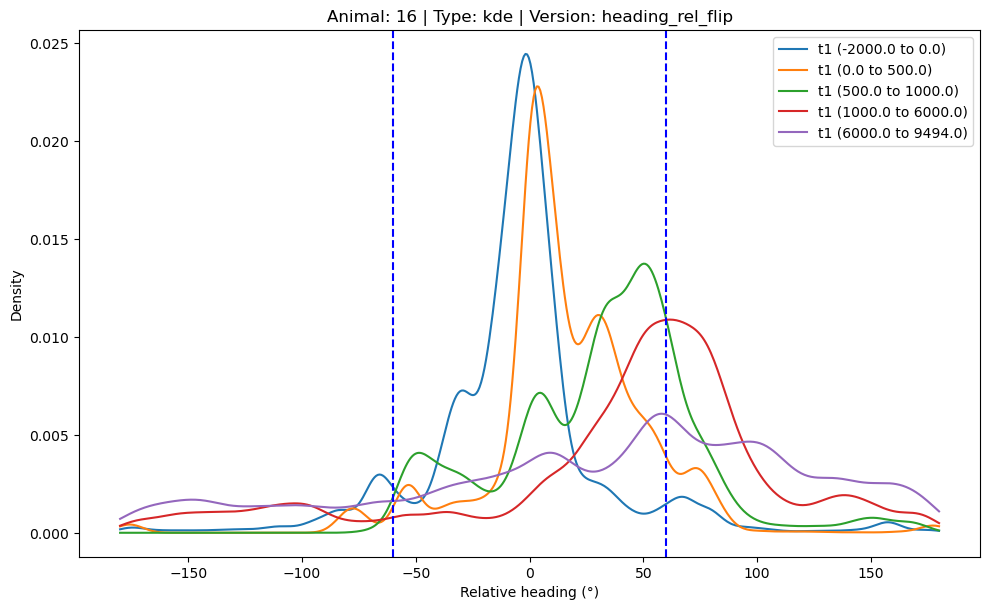

  Plotting for animal: 17


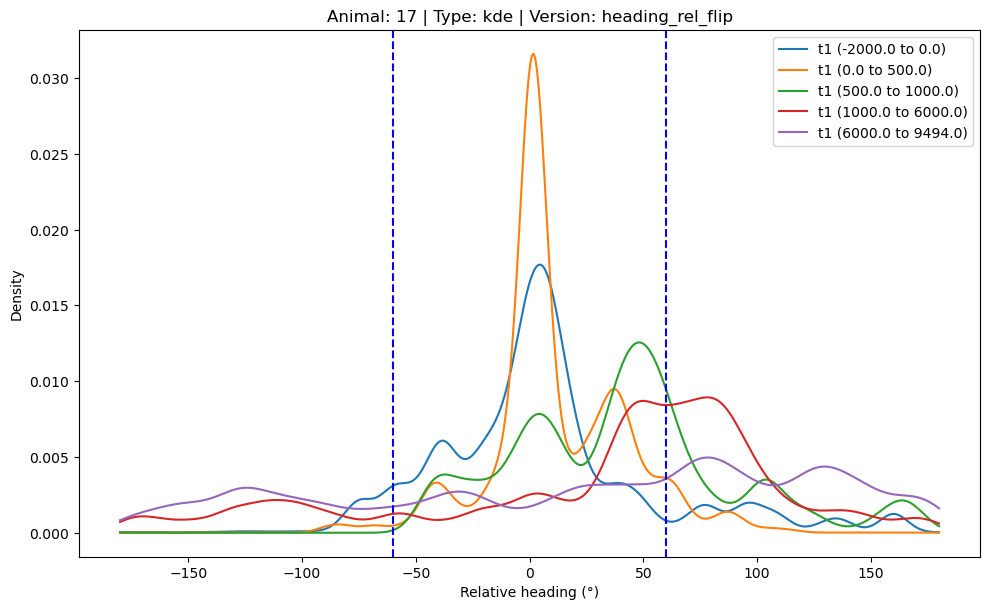

  Plotting for animal: 18


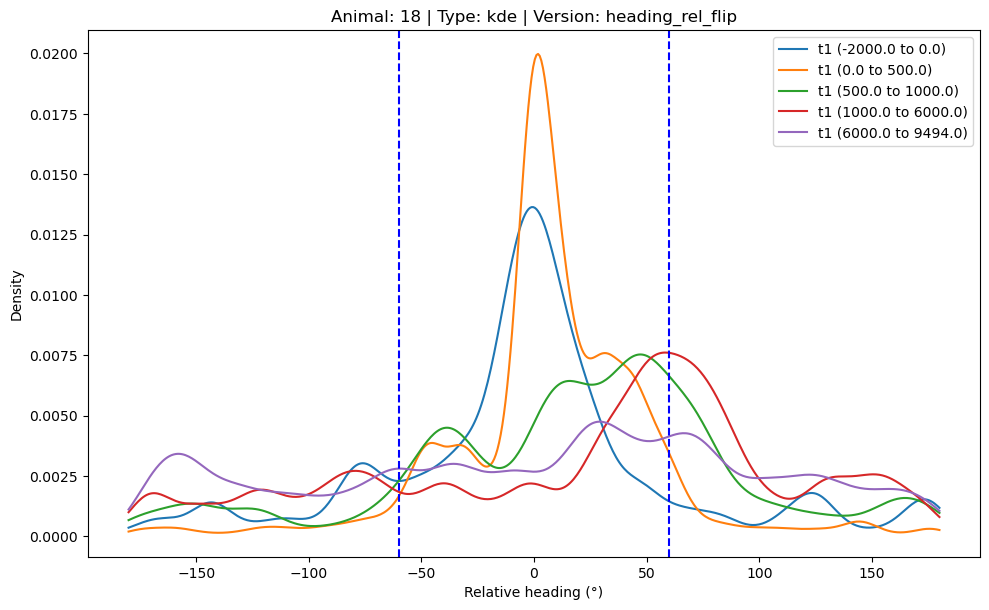

  Plotting for animal: 19


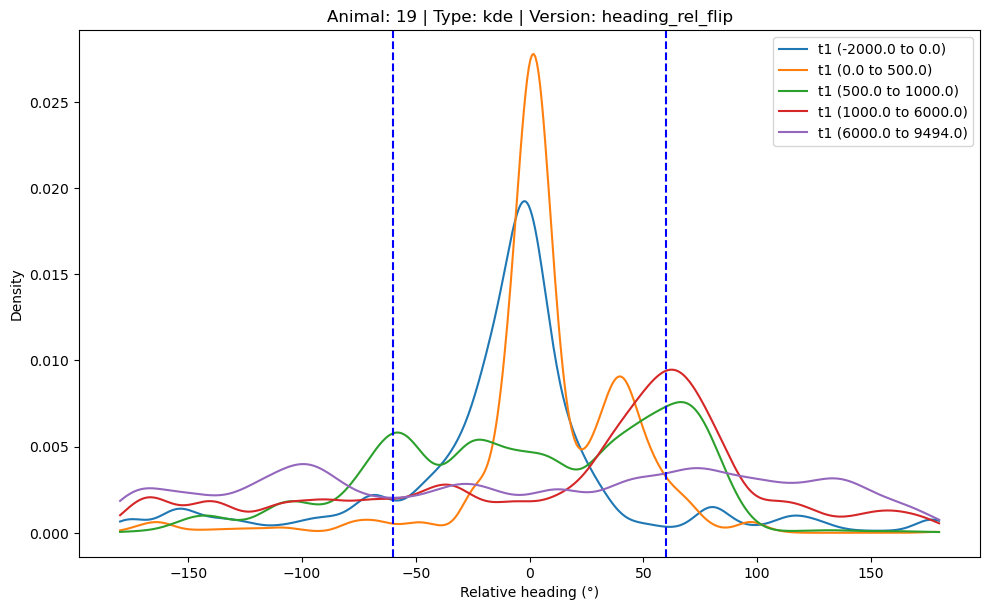

  Plotting for animal: 20


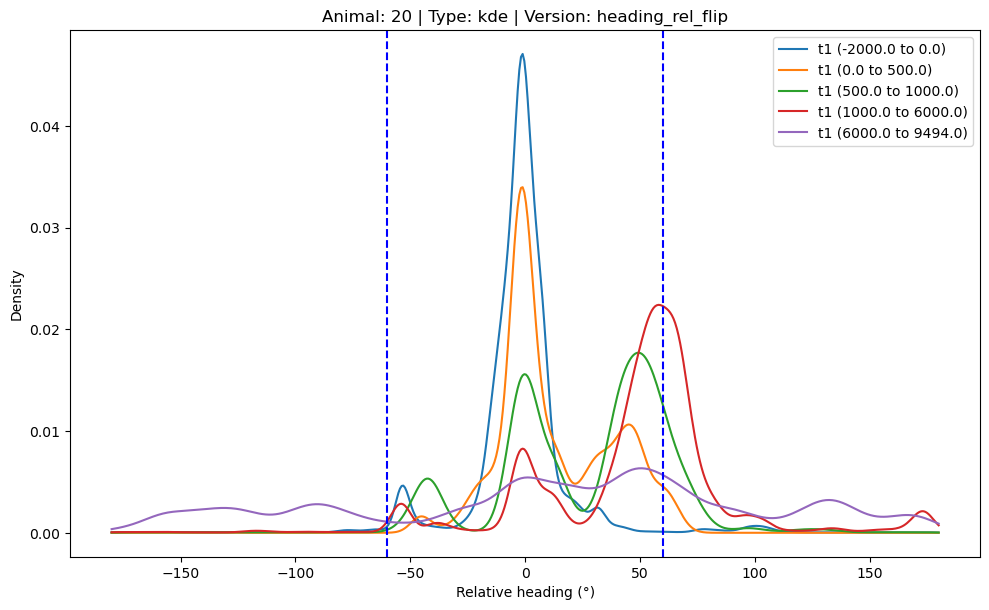

  Plotting for animal: 21


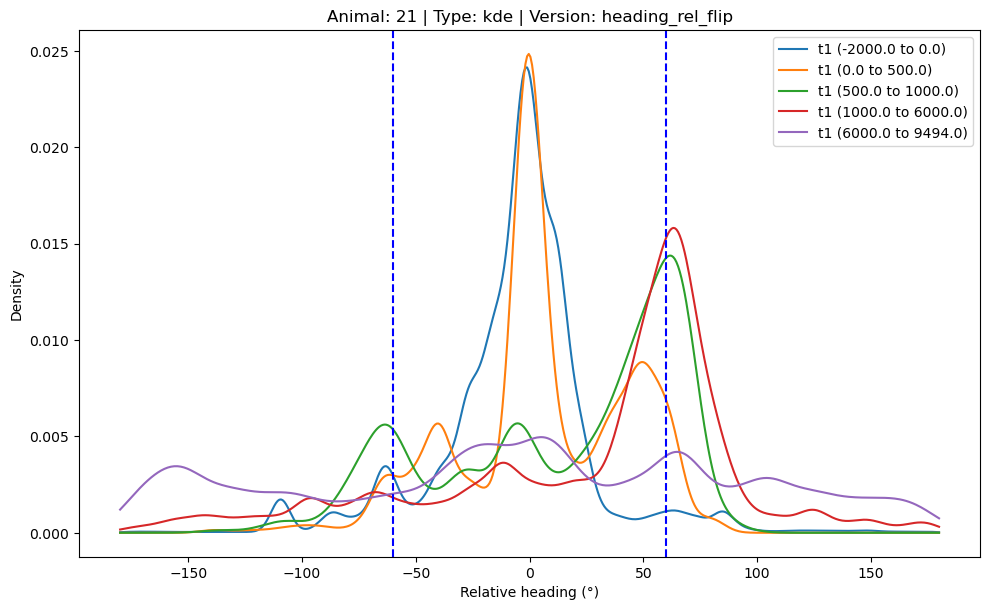

In [47]:
plot_type = ["kde"]
angle_version = ["heading_rel_flip"]

for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)

    for version in angle_version:
        print(f"Plot type: {type} | Angle version: {version}")

        for animal_id, df_animal in df.groupby("animal_id"):
            print(f"  Plotting for animal: {animal_id}")

            plt.figure(figsize=(10, 6))
            plt_density(df_animal, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
            plt.title(f"Animal: {animal_id} | Type: {type} | Version: {version}")

            filename = f"{type}_{version}_animal_{animal_id}.png"
            plt.savefig(os.path.join(save_path, filename), format='png', dpi=500)
            plt.show()

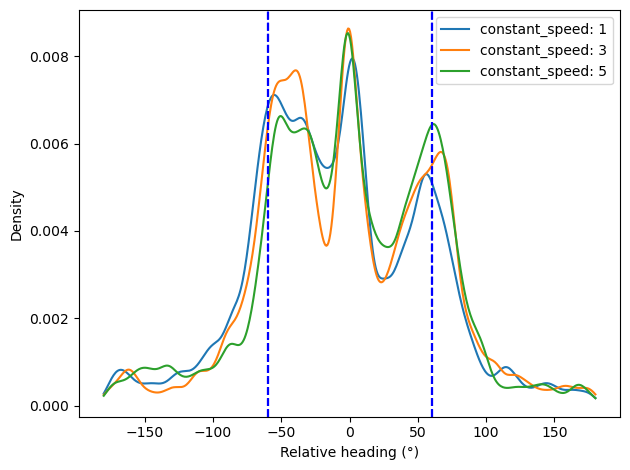

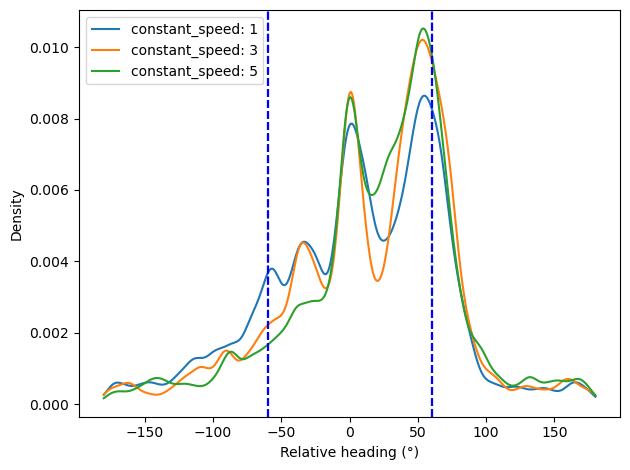

In [18]:
list_parameters = ["constant_speed"]

time_windows = generate_time_windows(critical_time2)
for version in angle_version:
    def group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=False):
        grouped = df.groupby(list_parameters)
        for groupvalues, group in grouped:
            label2 = ""
            for i in range(len(list_parameters)):
                if i > 0:
                    label2 += ", "
                label2 += f"{list_parameters[i]}: {groupvalues[i]}"
            plt_density(group, version, time_windows, angle_bins, plt_hist , plt_kde,label2=label2)
        plt.savefig(os.path.join(save_path, f'{list_parameters[i]}_{type}_{version}.png'), format='png', dpi=500)
        plt.show()
    group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=True)


['animal_id', 'trial_id', 'count_left', 'count_right', 'count_center', 'count_outside', 'fraction_left', 'fraction_right', 'fraction_center', 'fraction_outside', 'most_common_sector', 'mean_constant_speed', 'mean_constant_distance']


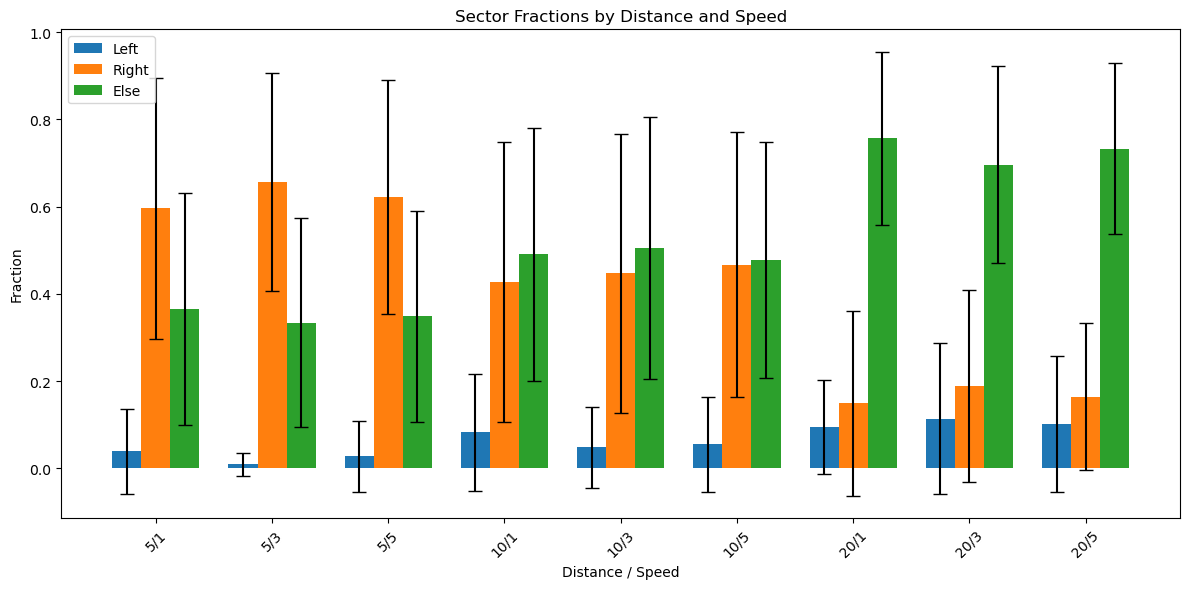

In [8]:
def compute_heading_sectors(df, angle_col='heading_rel_flip', trial_col='trial_id', animal_col='animal_id', t_col='ts', speed_col='constant_speed', distance_col='constant_distance'):
    df = df.copy()

    mu = [-60, 60]
    threshold = 20

    # Define sector boundaries
    left_bounds = (mu[0] - threshold, mu[0] + threshold)
    right_bounds = (mu[1] - threshold, mu[1] + threshold)
    center_bounds = (left_bounds[1], right_bounds[0])

    result_rows = []

    # Filter by ts window
    df = df[(df[t_col] >= 1000) & (df[t_col] < 6000)].copy()
    df['angle_deg'] = np.degrees(df[angle_col])

    for (animal, trial), group in df.groupby([animal_col, trial_col]):
        angles = group['angle_deg'].to_numpy()

        # Sector counts
        count_left = np.sum((angles >= left_bounds[0]) & (angles <= left_bounds[1]))
        count_right = np.sum((angles >= right_bounds[0]) & (angles <= right_bounds[1]))
        count_center = np.sum((angles > center_bounds[0]) & (angles < center_bounds[1]))
        count_outside = len(angles) - (count_left + count_right + count_center)

        # Determine dominant sector
        count_else = count_center + count_outside
        counts_comp = np.array([count_left, count_right, count_else])
        sectors_comp = ['left', 'right', 'else']
        most_common_sector = sectors_comp[np.argmax(counts_comp)]

        total = len(angles)

        # Summarize constant_speed and constant_distance (use mean here)
        mean_speed = group[speed_col].mean()
        mean_distance = group[distance_col].mean()

        result_rows.append({
            'animal_id': animal,
            'trial_id': trial,
            'count_left': count_left,
            'count_right': count_right,
            'count_center': count_center,
            'count_outside': count_outside,
            'fraction_left': count_left / total,
            'fraction_right': count_right / total,
            'fraction_center': count_center / total,
            'fraction_outside': count_outside / total,
            'most_common_sector': most_common_sector,
            'mean_constant_speed': round(mean_speed),
            'mean_constant_distance': round(mean_distance)
        })

    return pd.DataFrame(result_rows)

# Usage
results = compute_heading_sectors(df)
print(list(results))

# Add combined fraction
results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]

# Bin or round speed/distance to clean groupings (optional)
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Group and compute mean and std for each sector
grouped = results.groupby(["distance_bin", "speed_bin"])

plot_data = []
labels = []

for (dist, speed), group in grouped:
    labels.append(f"{dist}/{speed}")
    # PI = group["angle_deg"].mean() +
    plot_data.append({
        "mean_left": group["fraction_left"].mean(),
        "std_left": group["fraction_left"].std(),
        "mean_right": group["fraction_right"].mean(),
        "std_right": group["fraction_right"].std(),
        "mean_else": group["fraction_else"].mean(),
        "std_else": group["fraction_else"].std(),
        # "PI":
    })

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(plot_data, index=labels)

# Bar plot with error bars
x = np.arange(len(plot_df))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width, plot_df["mean_left"], width, yerr=plot_df["std_left"], label="Left", capsize=5)
ax.bar(x, plot_df["mean_right"], width, yerr=plot_df["std_right"], label="Right", capsize=5)
ax.bar(x + width, plot_df["mean_else"], width, yerr=plot_df["std_else"], label="Else", capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45)
ax.set_ylabel("Fraction")
ax.set_xlabel("Distance / Speed")
ax.set_title("Sector Fractions by Distance and Speed")
ax.legend()
plt.tight_layout()
plt.show()

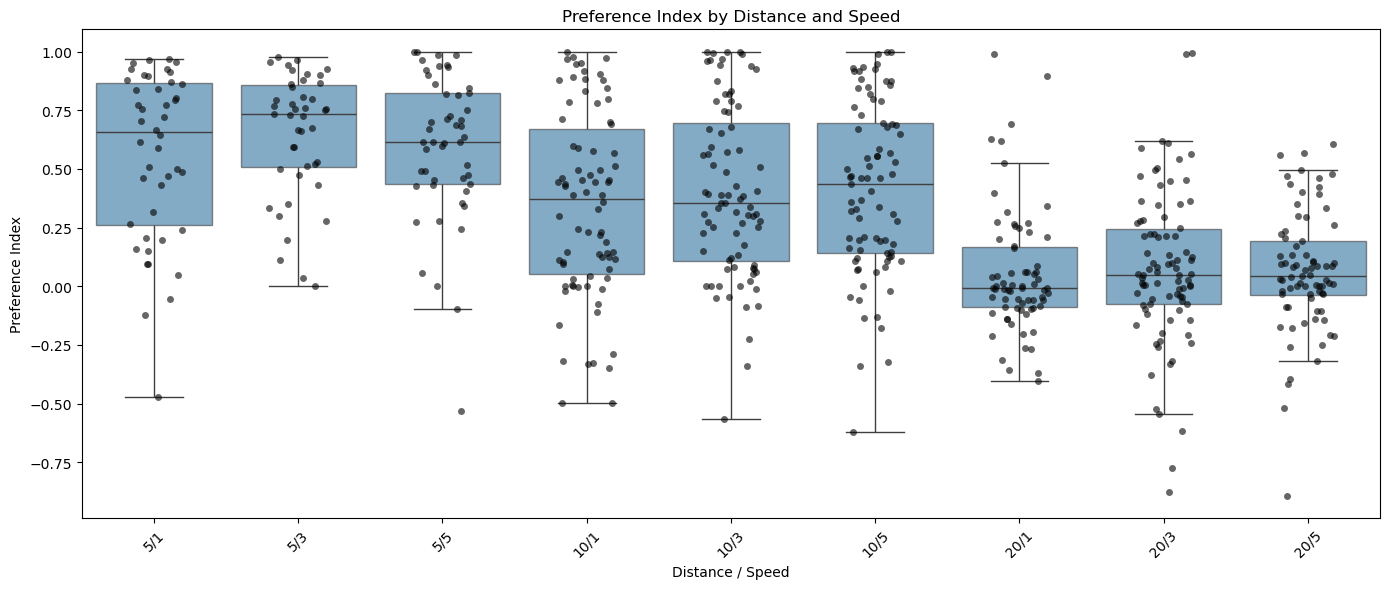

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute PI for each row ---
# results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]
results["target"] = results["fraction_left"] + results["fraction_right"]

# Avoid division by zero
denominator = results["fraction_left"] + results["fraction_right"] + results["fraction_else"]
# denominator = results["fraction_else"] + results["target"]
results["preference_index"] = (results["fraction_right"] - results["fraction_left"]) / denominator.replace(0, np.nan)
# results["preference_index"] = (results["target"] - results["fraction_else"]) / denominator.replace(0, np.nan)

# Bin speed and distance for grouping
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Create group label
results["group_label"] = results["distance_bin"].astype(str) + "/" + results["speed_bin"].astype(str)

# Sort by numeric bins
sorted_df = results.sort_values(["distance_bin", "speed_bin"])
label_order = sorted_df["group_label"].drop_duplicates()

# Then plot using the correct order
plt.figure(figsize=(14, 6))
sns.boxplot(x="group_label", y="preference_index", data=results,
            showfliers=False, boxprops={'alpha':0.6},
            order=label_order)
sns.stripplot(x="group_label", y="preference_index", data=results,
              color='black', alpha=0.6, jitter=0.2,
              order=label_order)

plt.xticks(rotation=45)
plt.ylabel("Preference Index")
plt.xlabel("Distance / Speed")
plt.title("Preference Index by Distance and Speed")
plt.tight_layout()
plt.show()

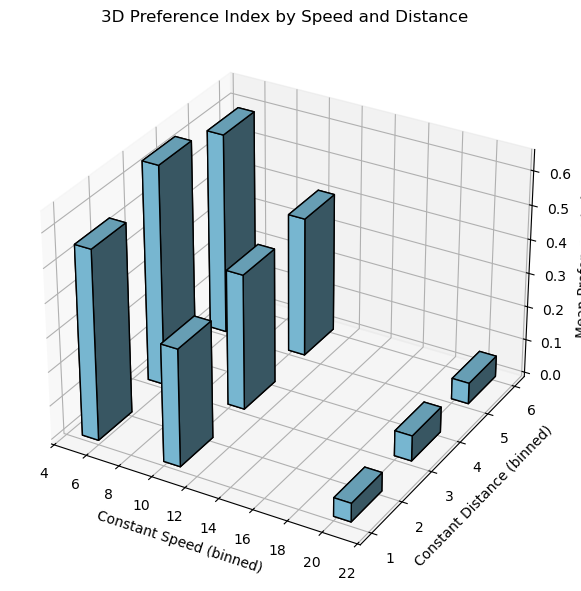

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Prepare data ---
results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]
results["target"] = results["fraction_left"] + results["fraction_right"]

# Avoid division by zero
denominator = results["target"] + results["fraction_else"]
results["preference_index"] = (results["fraction_right"] - results["fraction_left"]) / denominator.replace(0, np.nan)

# Bin speed and distance
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Group by bins and compute mean of the metric
grouped = results.groupby(["distance_bin", "speed_bin"])["preference_index"].mean().reset_index()

# Extract axes
y_vals = grouped["speed_bin"].values
x_vals = grouped["distance_bin"].values
z_vals = grouped["preference_index"].values

# Set width of bars
dx = dy = 1
dz = z_vals

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')

# Plot bars
ax.bar3d(x_vals, y_vals, np.zeros_like(dz), dx, dy, dz, shade=True, color='skyblue', edgecolor='k')

# Axis labels
ax.set_xlabel("Constant Speed (binned)")
ax.set_ylabel("Constant Distance (binned)")
ax.set_zlabel("Mean Preference Index")
ax.set_title("3D Preference Index by Speed and Distance")

plt.tight_layout()
plt.show()

/var/folders/yv/pwckh1jd1q7_mprkvx3pxgnm0000gp/T/ipykernel_60217/3664786956.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


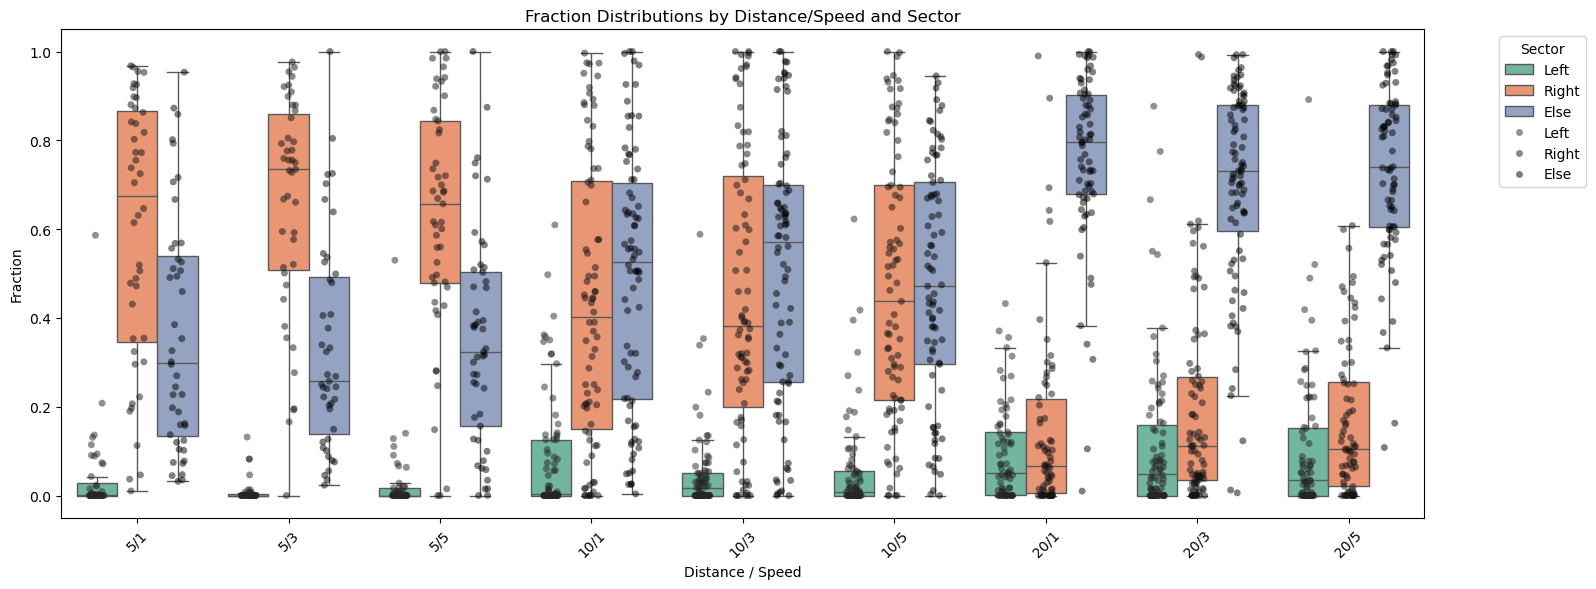

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the label
results["group_label"] = results["distance_bin"].astype(str) + "/" + results["speed_bin"].astype(str)

# Melt to long format
melted = pd.melt(
    results,
    id_vars=["group_label"],
    value_vars=["fraction_left", "fraction_right", "fraction_else"],
    var_name="fraction_type",
    value_name="value"
)

# Clean names
melted["fraction_type"] = melted["fraction_type"].str.replace("fraction_", "").str.capitalize()

# Sort group labels
sorted_labels = results.sort_values(["distance_bin", "speed_bin"])["group_label"].drop_duplicates()

# Plot
plt.figure(figsize=(16, 6))
sns.boxplot(
    x="group_label", y="value", hue="fraction_type", data=melted,
    showfliers=False, palette="Set2", order=sorted_labels
)
sns.stripplot(
    x="group_label", y="value", hue="fraction_type", data=melted,
    dodge=True, jitter=0.15, color='black', alpha=0.5, order=sorted_labels
)

plt.xticks(rotation=45)
plt.xlabel("Distance / Speed")
plt.ylabel("Fraction")
plt.title("Fraction Distributions by Distance/Speed and Sector")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
df = df.iloc[::100, :]  # Use every 10th row


import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
from tqdm import tqdm

save_path = "/Users/aljoscha/Downloads/locustVR_data"
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

def animate_angle_density(df, angle_version="heading_rel", ts_start=-2000, ts_end=9494, angle_bins=36, window_size=500, step_size=100, fps=100):
    df = df.copy()
    df = df.sort_values('ts')  # Ensure proper time ordering
    df = df[(df['ts'] >= ts_start) & (df['ts'] <= ts_end)]
    df['angle_deg'] = np.degrees(df[angle_version])

    time_vals = np.arange(ts_start + window_size / 2, ts_end - window_size / 2, step_size)
    x_vals = np.linspace(-180, 180, 500)
    kde_results = []

    # Rolling KDE for each window
    for center_ts in tqdm(time_vals, desc="Computing rolling KDE"):
        window_mask = (df['ts'] >= center_ts - window_size / 2) & (df['ts'] < center_ts + window_size / 2)
        window_data = df.loc[window_mask, 'angle_deg'].dropna()

        if len(window_data) < 10:
            kde_results.append(None)
        else:
            kde = gaussian_kde(window_data, bw_method='scott')
            kde_results.append(kde(x_vals))

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot([], [], lw=2)
    vline1 = ax.axvline(60, color='b', linestyle='--')
    vline2 = ax.axvline(-60, color='b', linestyle='--')
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 0.05)  # Adjust depending on your data
    ax.set_xlabel('Relative heading (°)')
    ax.set_ylabel('Density')
    ax.set_title('Density of Relative Heading Over Time')

    def update(frame_idx):
        kde_vals = kde_results[frame_idx]
        if kde_vals is not None:
            line.set_data(x_vals, kde_vals)
        else:
            line.set_data([], [])
        time_text.set_text(f'time: {time_vals[frame_idx]:.0f}')
        return line, time_text

    ani = FuncAnimation(fig, update, frames=len(time_vals), interval=1000 / fps, blit=True)
    plt.tight_layout()
    ani.save(os.path.join(save_path, 'heading_density.mp4'), fps=fps, dpi=150, writer='ffmpeg')
    plt.show()
print(1)

animate_angle_density(
    df=df,
    angle_version='heading_rel',  # or whatever your angle column is
    ts_start=-2000,
    ts_end=9000,
    angle_bins=np.linspace(-np.pi, np.pi, 36),
    window_size=500,
    step_size=100,
    fps=20
)

1


Computing rolling KDE:  48%|████▊     | 50/105 [00:25<00:27,  1.97it/s]


KeyboardInterrupt: 